## 1. Environment Setup
### 1.1. Imports

In [1]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import time
import gc
import joblib
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler

### 1.2. Configuration

In [2]:
BASE_INPUT_DIR = '/kaggle/input/fma-music-data/'
AUDIO_DIR = os.path.join(BASE_INPUT_DIR, 'fma_small/fma_small/')
METADATA_DIR = os.path.join(BASE_INPUT_DIR, 'fma_metadata/fma_metadata/')

WORK_DIR = '/kaggle/working/'
CACHE_DIR = os.path.join(WORK_DIR, 'augmented_rf_features_cache/')
os.makedirs(CACHE_DIR, exist_ok=True)

# --- Audio & Feature Parameters ---
SAMPLE_RATE = 22050
TRACK_DURATION = 29.0 # Use 29s to be safe with track lengths
N_MFCC = 20

# --- Augmentation Parameters ---
NOISE_LEVEL = 0.005
TIME_SHIFT_MAX_SECONDS = 2.0

# --- File Paths ---
TRAIN_FEATURES_PATH = os.path.join(CACHE_DIR, 'train_features_augmented.csv')
TEST_FEATURES_PATH = os.path.join(CACHE_DIR, 'test_features.csv')
MODEL_PATH = os.path.join(WORK_DIR, 'random_forest_augmented_model.joblib')
SCALER_PATH = os.path.join(WORK_DIR, 'feature_scaler.joblib')
LABEL_ENCODER_PATH = os.path.join(WORK_DIR, 'label_encoder.joblib')

print("Configuration is complete.")

Configuration is complete.


## 2. Data Loading and Initial Preparation

### 2.1. Load Metadata

In [3]:
def load_metadata(metadata_dir):
    """Loads and cleans the track metadata."""
    tracks = pd.read_csv(os.path.join(metadata_dir, 'tracks.csv'), index_col=0, header=[0, 1])
    tracks.columns = ['_'.join(col).strip() for col in tracks.columns.values]
    small_tracks = tracks[tracks['set_subset'] == 'small'].copy()
    small_tracks = small_tracks.dropna(subset=['track_genre_top'])
    return small_tracks

tracks_df = load_metadata(METADATA_DIR)
print(f"Metadata loaded. Shape: {tracks_df.shape}")

Metadata loaded. Shape: (8000, 52)


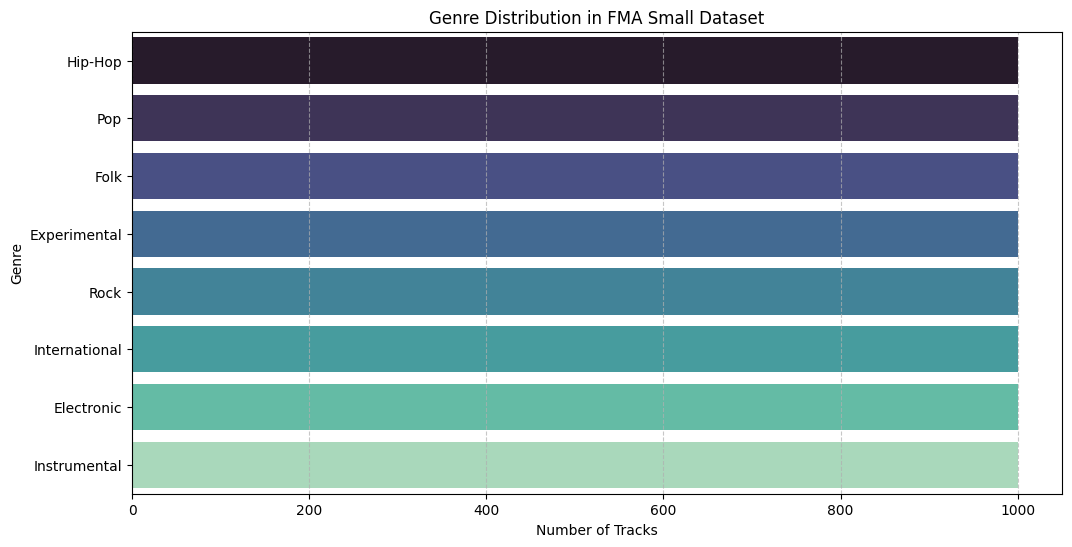

Analysis: The dataset is perfectly balanced, which is excellent for training a classifier without initial bias.


In [4]:
plt.figure(figsize=(12, 6))
sns.countplot(y=tracks_df['track_genre_top'], order=tracks_df['track_genre_top'].value_counts().index, palette='mako')
plt.title('Genre Distribution in FMA Small Dataset')
plt.xlabel('Number of Tracks')
plt.ylabel('Genre')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()
print("Analysis: The dataset is perfectly balanced, which is excellent for training a classifier without initial bias.")

### 2.2. Label Encoding and Data Splitting


In [5]:
le = LabelEncoder()
tracks_df['genre_encoded'] = le.fit_transform(tracks_df['track_genre_top'])
joblib.dump(le, LABEL_ENCODER_PATH)
print(f"Genres: {list(le.classes_)}")

train_df, test_df = train_test_split(
    tracks_df,
    test_size=0.2,
    random_state=42,
    stratify=tracks_df['genre_encoded']
)
print(f"\nData split into {len(train_df)} training and {len(test_df)} testing samples.")

Genres: ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock']

Data split into 6400 training and 1600 testing samples.


## 3. Advanced Feature Extraction and Augmentation
### 3.1. Augmentation and Feature Extraction Functions

In [6]:
def add_noise(y, noise_level):
    """Adds Gaussian noise to the signal."""
    noise = np.random.randn(len(y))
    augmented_y = y + noise_level * noise
    return augmented_y

def time_shift(y, sr, max_shift_seconds):
    """Shifts the signal in time."""
    shift_samples = int(np.random.uniform(-max_shift_seconds, max_shift_seconds) * sr)
    return np.roll(y, shift_samples)

In [7]:
from scipy.stats import skew, kurtosis

def extract_features(y, sr):
    """Extracts a rich set of statistical features from an audio signal."""
    features = {}
    
    # ZCR and RMS
    features['zcr_mean'] = np.mean(librosa.feature.zero_crossing_rate(y))
    features['zcr_std'] = np.std(librosa.feature.zero_crossing_rate(y))
    features['rms_mean'] = np.mean(librosa.feature.rms(y=y))
    features['rms_std'] = np.std(librosa.feature.rms(y=y))

    # Spectral Features
    spec_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    features['spec_centroid_mean'] = np.mean(spec_centroid)
    features['spec_centroid_std'] = np.std(spec_centroid)
    
    spec_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    features['spec_bandwidth_mean'] = np.mean(spec_bandwidth)
    features['spec_bandwidth_std'] = np.std(spec_bandwidth)

    # MFCCs (Mean, Std, Skew, Kurtosis)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=N_MFCC)
    features.update({f'mfcc_{i}_mean': v for i, v in enumerate(np.mean(mfccs, axis=1))})
    features.update({f'mfcc_{i}_std': v for i, v in enumerate(np.std(mfccs, axis=1))})
    features.update({f'mfcc_{i}_skew': v for i, v in enumerate(skew(mfccs, axis=1))})
    features.update({f'mfcc_{i}_kurt': v for i, v in enumerate(kurtosis(mfccs, axis=1))})

    # Chroma Features
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    features.update({f'chroma_{i}_mean': v for i, v in enumerate(np.mean(chroma, axis=1))})
    features.update({f'chroma_{i}_std': v for i, v in enumerate(np.std(chroma, axis=1))})
    
    return features

### 3.2. Processing Pipeline

In [ ]:
def create_feature_dataset(df, cache_path, augment=False):
    """
    Creates or loads a dataset of audio features.
    Applies augmentation if specified.
    """
    if os.path.exists(cache_path):
        print(f"Loading cached features from {cache_path}...")
        return pd.read_csv(cache_path, index_col=0)

    desc = "Extracting Augmented Features" if augment else "Extracting Test Features"
    print(desc)
    
    feature_list = []
    for track_id, row in tqdm(df.iterrows(), total=len(df), desc=desc):
        tid_str = f'{track_id:06d}'
        file_path = os.path.join(AUDIO_DIR, tid_str[:3], tid_str + '.mp3')
        if not os.path.exists(file_path):
            continue
        
        try:
            y, sr = librosa.load(file_path, sr=SAMPLE_RATE, duration=TRACK_DURATION)
            
            # Original features
            original_features = extract_features(y, sr)
            original_features['track_id'] = track_id
            feature_list.append(original_features)
            
            # Augmented features (only for training set)
            if augment:
                # Version with noise
                y_noisy = add_noise(y, NOISE_LEVEL)
                noisy_features = extract_features(y_noisy, sr)
                noisy_features['track_id'] = track_id
                feature_list.append(noisy_features)
                
                # Version with time shift
                y_shifted = time_shift(y, sr, TIME_SHIFT_MAX_SECONDS)
                shifted_features = extract_features(y_shifted, sr)
                shifted_features['track_id'] = track_id
                feature_list.append(shifted_features)

        except Exception as e:
            print(f"Error processing {file_path}: {e}")

    features_df = pd.DataFrame(feature_list).set_index('track_id')
    features_df.to_csv(cache_path)
    print(f"Features saved to {cache_path}")
    return features_df

X_train = create_feature_dataset(train_df, TRAIN_FEATURES_PATH, augment=True)
# For the test set, we DO NOT apply augmentation.
X_test = create_feature_dataset(test_df, TEST_FEATURES_PATH, augment=False)

y_train = train_df.loc[X_train.index]['genre_encoded']
y_test = test_df.loc[X_test.index]['genre_encoded']

print(f"\nFinal training data shape: {X_train.shape}")
print(f"Final testing data shape:  {X_test.shape}")

### 3.4. Post-Extraction EDA: Analyzing the Engineered Features



Loading already extracted features from /kaggle/working/augmented_rf_features_cache/train_features_no_aug.csv...

Descriptive Statistics for Engineered Features:


,zcr_mean,zcr_std,rms_mean,rms_std,spec_centroid_mean,spec_centroid_std,spec_bandwidth_mean,spec_bandwidth_std,mfcc_0_mean,mfcc_1_mean,...,chroma_2_std,chroma_3_std,chroma_4_std,chroma_5_std,chroma_6_std,chroma_7_std,chroma_8_std,chroma_9_std,chroma_10_std,chroma_11_std
count,6399.000000,6399.000000,6399.000000,6399.000000,6399.000000,6399.000000,6399.000000,6399.000000,6399.000000,6399.000000,...,6399.000000,6399.000000,6399.000000,6399.000000,6399.000000,6399.000000,6399.000000,6399.000000,6399.000000,6399.000000
mean,0.084112,0.041350,0.181108,0.057461,1898.847969,616.271093,2087.206493,407.703151,-134.295294,110.835988,...,0.274088,0.245205,0.270850,0.258638,0.251642,0.275063,0.249546,0.279642,0.246809,0.262388
std,0.044126,0.025664,0.098471,0.031414,710.702531,314.058126,555.695847,181.734848,105.311148,37.925895,...,0.065391,0.062224,0.064455,0.067021,0.064093,0.065576,0.062862,0.065252,0.064238,0.064551
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1131.371000,-58.327976,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.053848,0.023310,0.108248,0.034211,1383.952820,379.508506,1754.646172,275.688147,-192.724525,85.262980,...,0.235896,0.206335,0.232825,0.217934,0.212857,0.237401,0.212122,0.241952,0.206968,0.223538
50%,0.076752,0.035673,0.169668,0.051421,1889.585055,578.755515,2157.840058,397.633621,-118.683670,106.765950,...,0.279005,0.249184,0.277267,0.263911,0.255426,0.281211,0.253730,0.287469,0.250550,0.267639
75%,0.105379,0.053002,0.241250,0.074561,2363.844025,809.041256,2488.381507,516.679233,-59.871441,132.755445,...,0.318310,0.287574,0.315329,0.303589,0.294405,0.319018,0.292900,0.325069,0.291280,0.307543
max,0.603359,0.218513,0.871824,0.268415,6429.413931,2264.169607,3486.052467,1396.995092,175.633210,257.367340,...,0.466209,0.442844,0.455606,0.453894,0.451677,0.462478,0.456946,0.451978,0.456278,0.466871



Distribution of Key Features Across Genres:


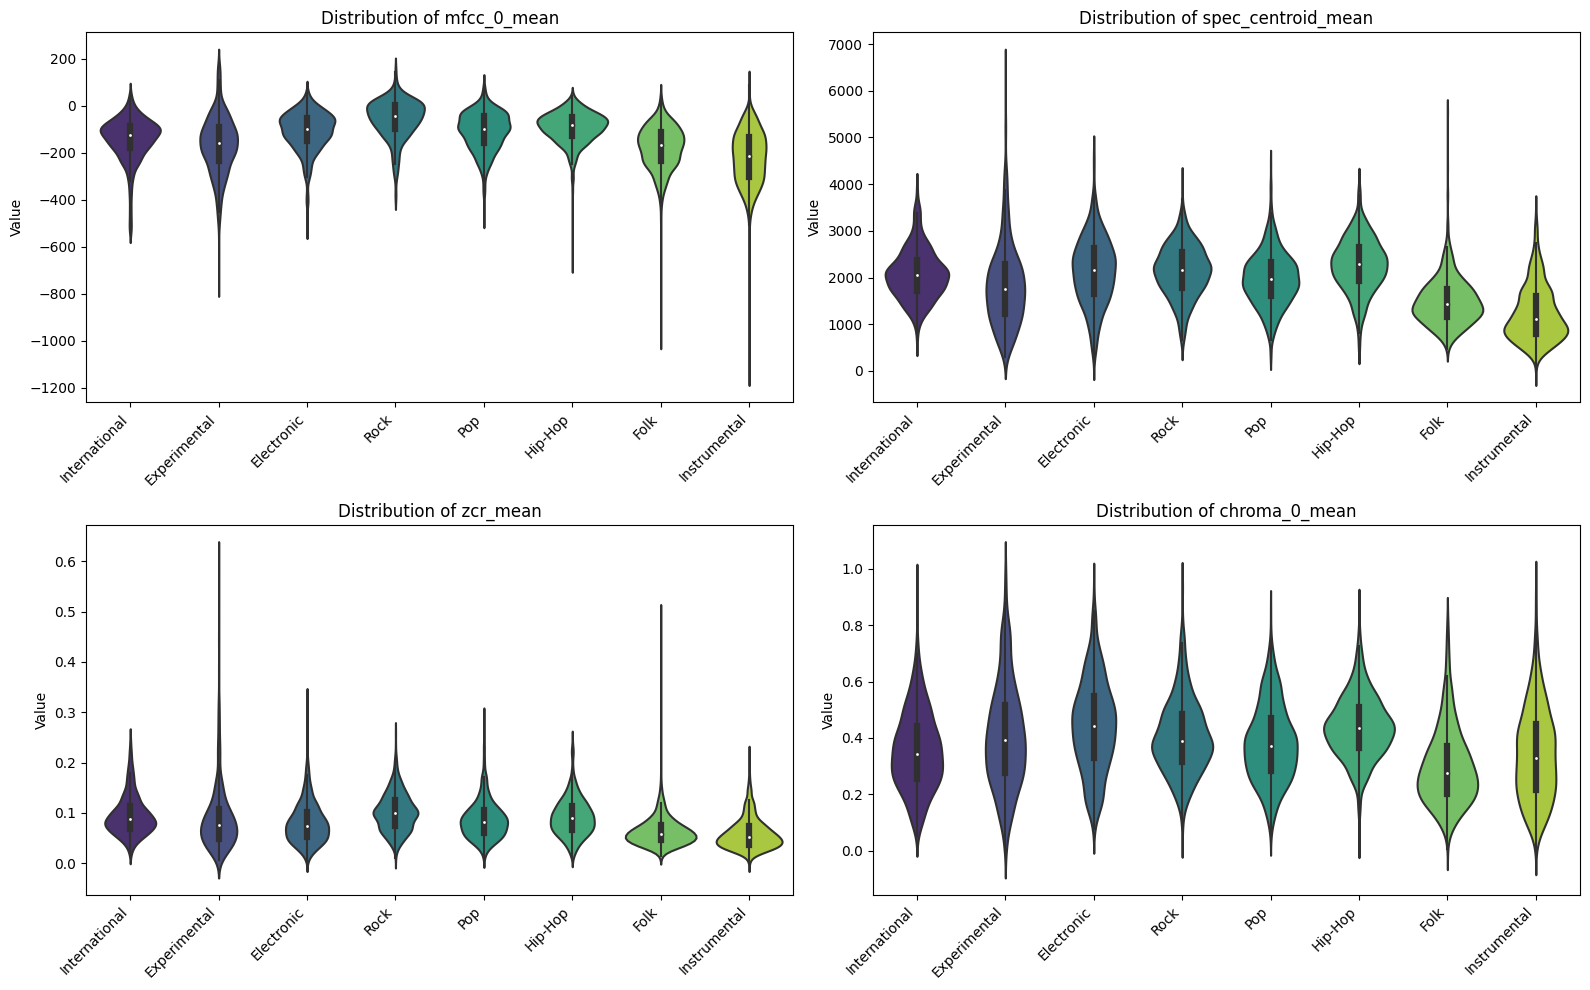

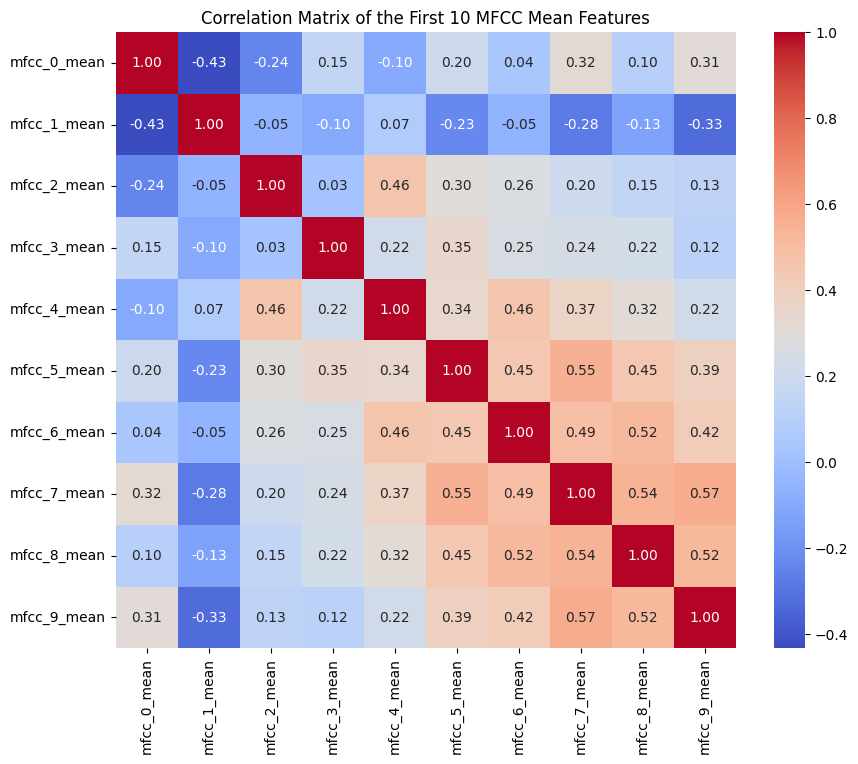

51410

In [12]:
TRAIN_FEATURES_NO_AUG_PATH = os.path.join(CACHE_DIR, 'train_features_no_aug.csv')

print(f"Loading already extracted features from {TRAIN_FEATURES_NO_AUG_PATH}...")
X_train_no_aug = pd.read_csv(TRAIN_FEATURES_NO_AUG_PATH, index_col=0)

y_train_no_aug = train_df.loc[X_train_no_aug.index]['genre_encoded']

eda_df = X_train_no_aug.copy()

eda_df['genre'] = le.inverse_transform(y_train_no_aug)

print("\nDescriptive Statistics for Engineered Features:")
display(eda_df.describe())

key_features = [
    'mfcc_0_mean', 'spec_centroid_mean', 'zcr_mean', 'chroma_0_mean'
]
print("\nDistribution of Key Features Across Genres:")
plt.figure(figsize=(16, 10))
for i, feature in enumerate(key_features):
    plt.subplot(2, 2, i + 1)
    sns.violinplot(data=eda_df, x='genre', y=feature, palette='viridis')
    plt.title(f'Distribution of {feature}')
    plt.xticks(rotation=45, ha='right')
    plt.xlabel('')
    plt.ylabel('Value')
plt.tight_layout()
plt.show()

# Feature Correlation
mfcc_mean_features = [f'mfcc_{i}_mean' for i in range(10)]
plt.figure(figsize=(10, 8))
correlation_matrix = eda_df[mfcc_mean_features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of the First 10 MFCC Mean Features')
plt.show()

# Clean up the temporary dataframe to save memory
del X_train_no_aug, y_train_no_aug, eda_df
gc.collect()

## 4. Model Training (XGBoost)
### 4.1. Feature Scaling

In [14]:
print("\nScaling features...")

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)

X_test_scaled = scaler.transform(X_test)

joblib.dump(scaler, SCALER_PATH)

print(f"Scaler has been fitted and saved to {SCALER_PATH}")
print(f"Shape of scaled training data: {X_train_scaled.shape}")
print(f"Shape of scaled test data: {X_test_scaled.shape}")


Scaling features...
Scaler has been fitted and saved to /kaggle/working/feature_scaler.joblib
Shape of scaled training data: (19197, 112)
Shape of scaled test data: (1598, 112)


### 4.2. XGBoost Model Training

In [15]:
print("\nTraining XGBoost model...")
start_time = time.time()

xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=len(le.classes_),
    n_estimators=2000,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,             
    colsample_bytree=0.8,       
    use_label_encoder=False,    
    eval_metric='mlogloss',    
    n_jobs=-1,                 
    random_state=42
)

xgb_model.fit(
    X_train_scaled,
    y_train,
    early_stopping_rounds=50,
    eval_set=[(X_test_scaled, y_test)],
    verbose=False
)

training_time = time.time() - start_time
print(f"XGBoost training complete in {training_time:.2f} seconds.")
print(f"Best iteration found by early stopping: {xgb_model.best_iteration}")

joblib.dump(xgb_model, MODEL_PATH)
print(f"Model saved to {MODEL_PATH}")


Training XGBoost model...


/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBoost training complete in 53.77 seconds.
Best iteration found by early stopping: 484
Model saved to /kaggle/working/random_forest_augmented_model.joblib


## 5. Evaluation

In [16]:
print("\nEvaluating model on the test set...")
y_pred = xgb_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)

print("-" * 50)
print(f"Final Test Accuracy: {accuracy:.4f}")
print("-" * 50)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))


Evaluating model on the test set...
--------------------------------------------------
Final Test Accuracy: 0.5551
--------------------------------------------------

Classification Report:
               precision    recall  f1-score   support

   Electronic       0.55      0.50      0.52       199
 Experimental       0.55      0.39      0.46       199
         Folk       0.64      0.72      0.68       200
      Hip-Hop       0.61      0.68      0.64       200
 Instrumental       0.51      0.64      0.57       200
International       0.59      0.56      0.58       200
          Pop       0.39      0.37      0.38       200
         Rock       0.60      0.58      0.59       200

     accuracy                           0.56      1598
    macro avg       0.55      0.55      0.55      1598
 weighted avg       0.55      0.56      0.55      1598



### 5.2. Confusion Matrix

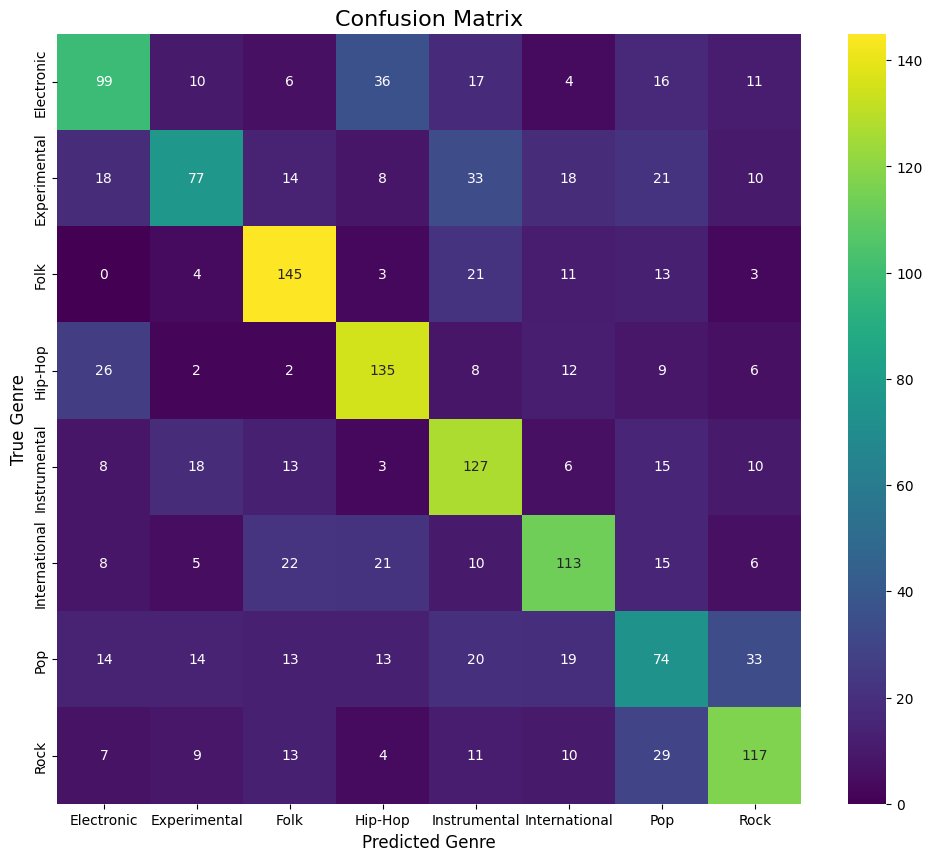

In [17]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Genre', fontsize=12)
plt.ylabel('True Genre', fontsize=12)
plt.show()

### 5.3. Feature Importance

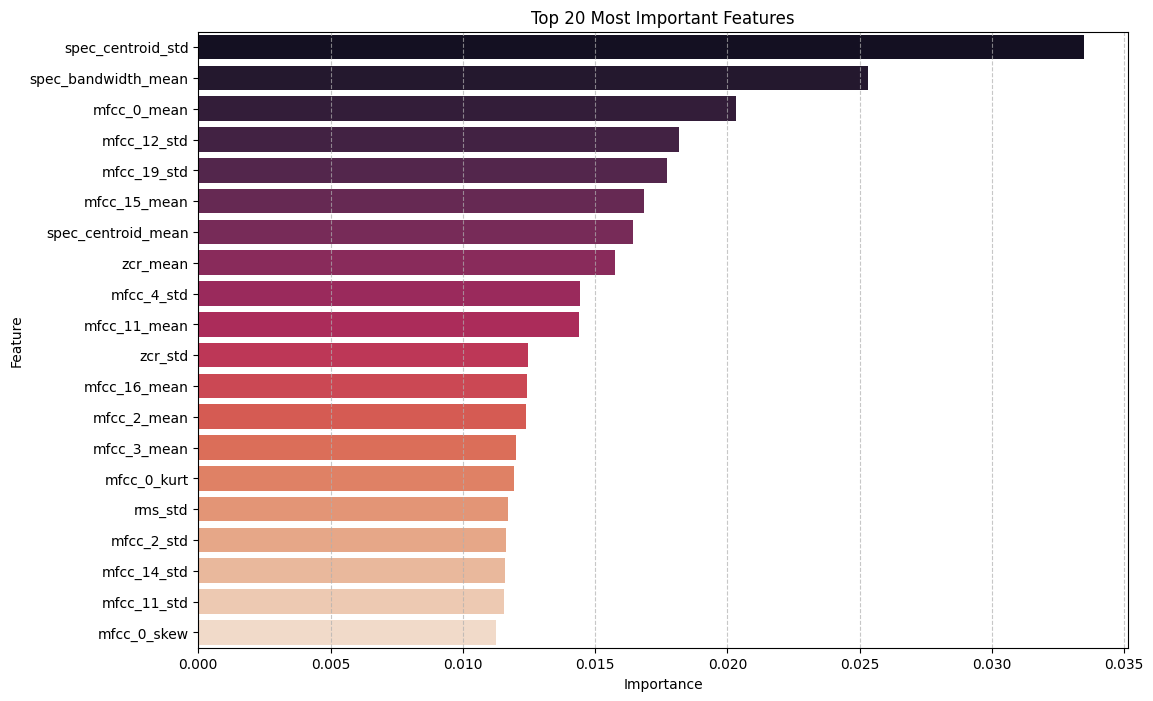


Analysis of Feature Importance:
- The plot shows which acoustic characteristics the model found most useful for classification.
- Typically, the mean and standard deviation of the first few MFCCs are highly important, as they capture the core timbral quality of the sound.
- Spectral features like centroid and bandwidth also tend to be very informative.
- This analysis provides valuable insights into what makes different music genres unique from a signal processing perspective.



In [18]:
importances = xgb_model.feature_importances_
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(20), palette='rocket')
plt.title('Top 20 Most Important Features')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

print("""
Analysis of Feature Importance:
- The plot shows which acoustic characteristics the model found most useful for classification.
- Typically, the mean and standard deviation of the first few MFCCs are highly important, as they capture the core timbral quality of the sound.
- Spectral features like centroid and bandwidth also tend to be very informative.
- This analysis provides valuable insights into what makes different music genres unique from a signal processing perspective.
""")